In [2]:
import os
import numpy as np
import math
import time as time


# Import torch and select GPU
import torch
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

# Import metrics functions
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim



True
1
0
NVIDIA A100-PCIE-40GB


## Set hyperparameters 

In [7]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = 'M31'
# Input noise level
input_snr = 30.

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20



# Prepare observations 

In [8]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y!=0].shape)
n_im = rng.normal(0, eff_sigma, y[y!=0].shape)
# Add noise
y[y!=0] += (n_re + 1.j*n_im)

# Observation
torch_y = torch.tensor(
    np.copy(y), device=device, dtype=myComplexType
).reshape((1,) + img.shape)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))


INSTRUME                                                                         [astropy.io.fits.card]


# Define likelihood and prior

In [9]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()


In [10]:
# Load CRR model
torch.set_grad_enabled(False)
# torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
if device.type == 'cpu':
    CRR_model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cpu', device_type='cpu')
elif device.type == 'cuda':
    CRR_model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda', device_type='gpu')


print(f'Numbers of parameters before prunning: {CRR_model.num_params}')
CRR_model.prune()
print(f'Numbers of parameters after prunning: {CRR_model.num_params}')



--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [11]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


Lipschitz bound 0.781


# Run optimisation algorithm anc compute the MAP reconstruction

In [12]:
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)

x_hat = qai.optim.FISTA_CRR_torch(
    x_init=x_init,
    options=options,
    likelihood=likelihood,
    prox_op=prox_op,
    CRR_model=CRR_model,
    alpha=alpha,
    lmbd=lmbd,
    mu=mu,
)



[GD] 0 out of 15000 iterations, tol = 0.017043
[GD] 100 out of 15000 iterations, tol = 0.002369
[GD] 200 out of 15000 iterations, tol = 0.000744
[GD] 300 out of 15000 iterations, tol = 0.000317
[GD] 400 out of 15000 iterations, tol = 0.000190
[GD] 500 out of 15000 iterations, tol = 0.000064
[GD] 600 out of 15000 iterations, tol = 0.000080
[GD] 700 out of 15000 iterations, tol = 0.000037
[GD] 800 out of 15000 iterations, tol = 0.000038
[GD] 900 out of 15000 iterations, tol = 0.000024
[GD] 1000 out of 15000 iterations, tol = 0.000013
[GD] converged in 1005 iterations


# Plot MAP reconstruction

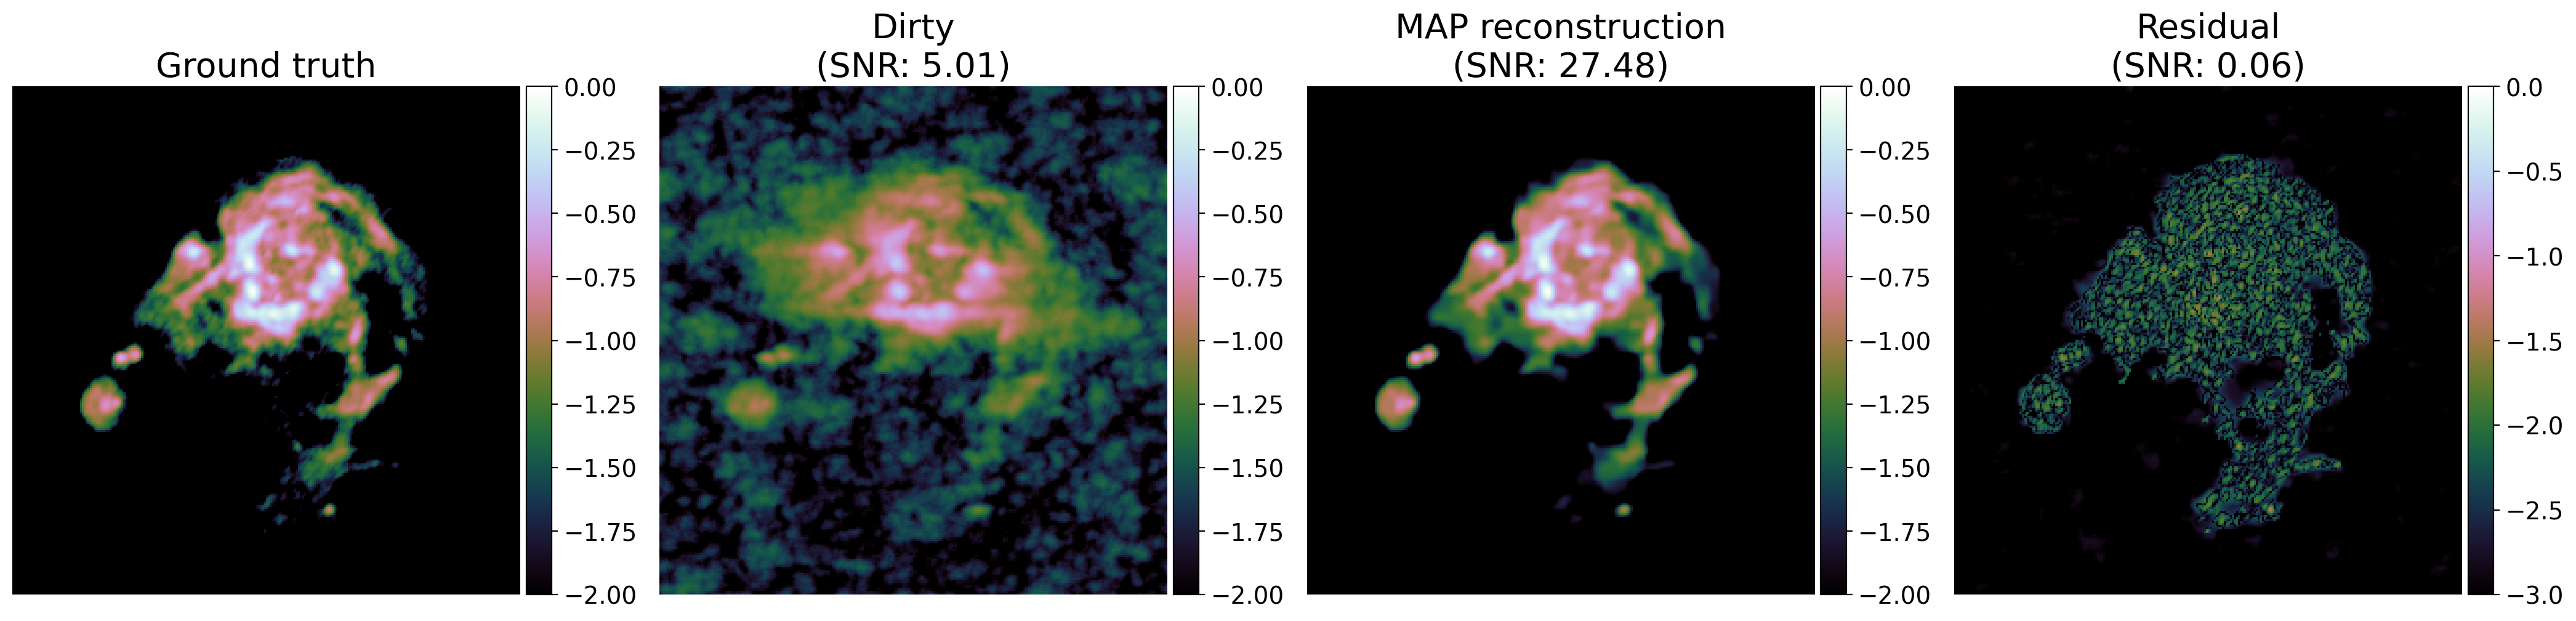

In [24]:
# Convert to numpy
np_x_init = to_numpy(x_init)
np_x = np.copy(x)
np_x_hat = to_numpy(x_hat)

# Need to replace zero values with veery small numbers for the log plots
np_x[np_x == 0] = np.random.rand(np.sum(np_x == 0)) * 1e-7

images = [np_x, np_x_init, np_x_hat, np_x - np.abs(np_x_hat)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = 'cubehelix'

fig, axs = plt.subplots(1,4, figsize=(26,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(
        np.log10(np.abs(images[i])),
        cmap=cmap,
        vmax=0,
        vmin=vmin_log[i]
    )
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=14)
    if i > 0:   
        stats_str = '\n(SNR: {})'.format(
            round(qai.utils.eval_snr(x, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis('off')
plt.show()


